<a href="https://colab.research.google.com/github/tonistark23/DataMiningLab2_Kaggle/blob/master/108065435_Tweet_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preparation

In [2]:
# import libraries
from google.colab import drive
drive.mount('/content/drive')
from google.colab import files

import numpy as np 
import pandas as pd
from pandas.io.json import json_normalize
import seaborn as sns
import nltk
import tqdm as tqdm
import matplotlib.pyplot as plt
from wordcloud import WordCloud

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# load data
emotion = pd.read_csv("/content/drive/My Drive/Colab Notebooks/lab2/emotion.csv")

# load pkl
all_df = pd.read_pickle("/content/drive/My Drive/Colab Notebooks/lab2/all_df_stopwords2lw_wordemojis_preservecaps.pkl")

# split into train and test
test_df = all_df[all_df['identification']=='test']
train_df = all_df[all_df['identification']=='train']
train_df = pd.merge(train_df, emotion, on='tweet_id')

# Data Exploration

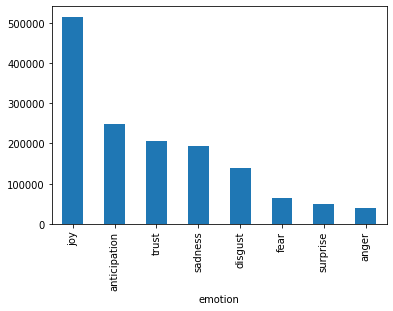

In [0]:
# see emotion distribution
graph = train_df.groupby(['emotion']).count()['text'].sort_values(ascending=False)
graph.plot.bar()

Above is the distribution of emotions in the TRAIN dataset. We can see an imbalance (JOY has the most number of records than any other category). We might have to account for this later on.

In [0]:
# function referenced from https://www.analyticsvidhya.com/blog/2019/04/predicting-movie-genres-nlp-multi-label-classification/
# slightly modified by me

def freq_words(x, terms, title): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,4)) 
  ax = sns.barplot(data=d, x= "word", y = "count") 
  ax.set(ylabel = 'Word') 
  ax.set_title(title)
  plt.show()

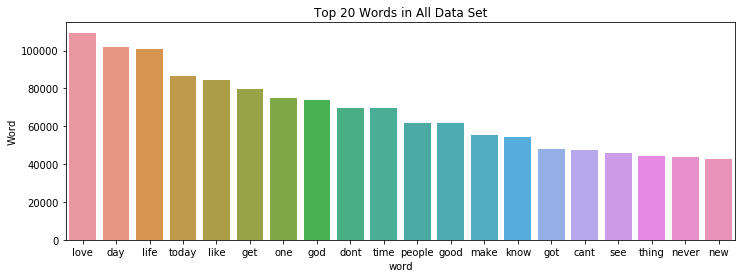

In [0]:
# most frequent words in cleaned text

freq_words(all_df['cleanedText'], 20, "Top 20 Words in All Data Set")

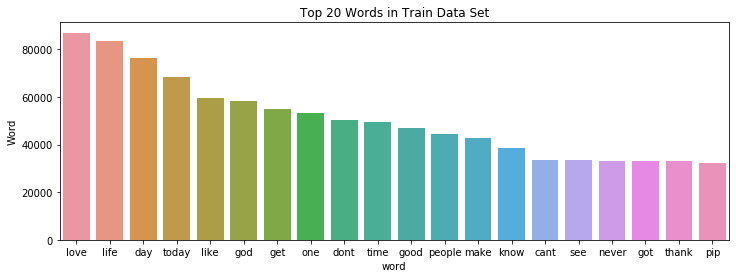

In [0]:
freq_words(train_df['cleanedText'], 20, "Top 20 Words in Train Data Set")

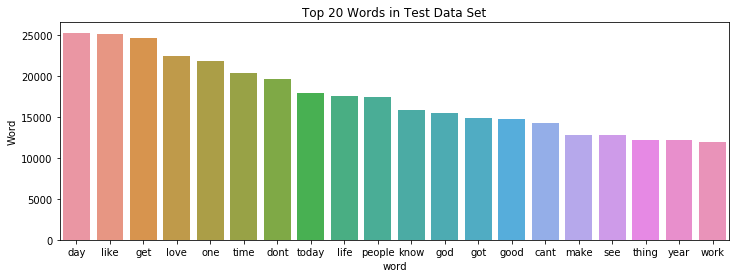

In [0]:
freq_words(test_df['cleanedText'], 20, "Top 20 Words in Test Data Set")

After cleaning the text and looking at the most frequent words in train+test combined (all data set), train data set, and test data set, we can see the following:
- top words in train match top words in ALL
- most words in test also match top words in both train and ALL, but order is different
- this may imply (but needs confirmation) that train and test data sets MAY have similar emotion distributions. 

We will also need to keep this in mind when trying to improve the precision, recall, and accuracy of our model.

In [0]:
# word cloud per category
def gen_cloud(words): 
  text = " ".join(review for review in words)
  
  wordcloud = WordCloud(background_color ='white', min_font_size = 10).generate(text)
                
  # plot the WordCloud image                        
  plt.figure(figsize = (8, 8), facecolor = None) 
  plt.imshow(wordcloud) 
  plt.axis("off") 
  plt.tight_layout(pad = 0)  
  plt.show() 

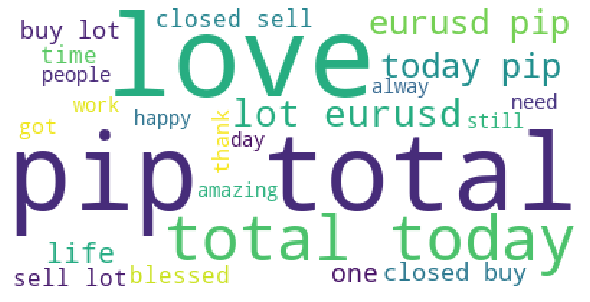

In [0]:
gen_cloud(train_df[train_df['emotion']=='joy']['cleanedText'])

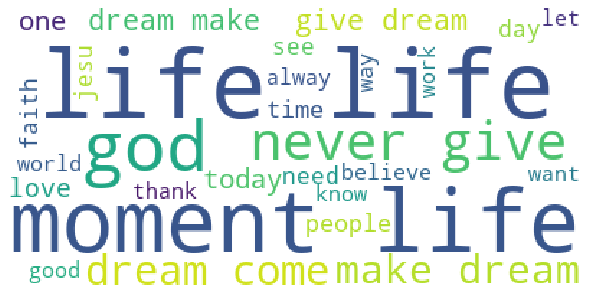

In [0]:
gen_cloud(train_df[train_df['emotion']=='anticipation']['cleanedText'])

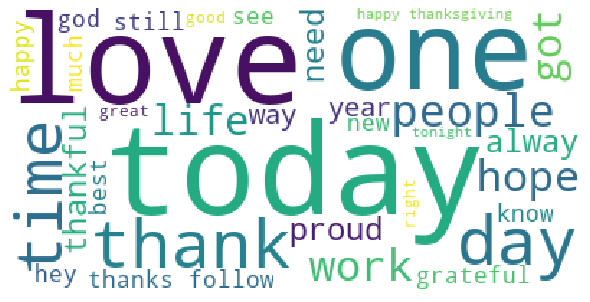

In [0]:
gen_cloud(train_df[train_df['emotion']=='trust']['cleanedText'])

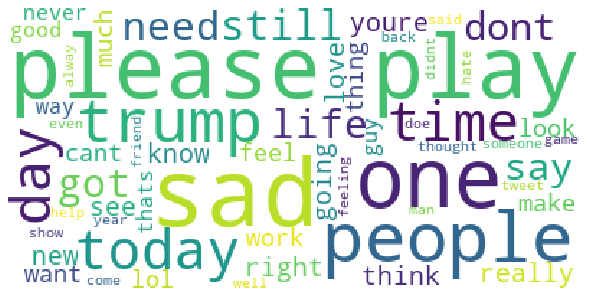

In [0]:
gen_cloud(train_df[train_df['emotion']=='sadness']['cleanedText'])

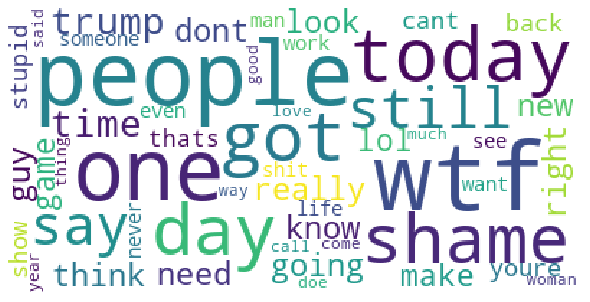

In [0]:
gen_cloud(train_df[train_df['emotion']=='disgust']['cleanedText'])

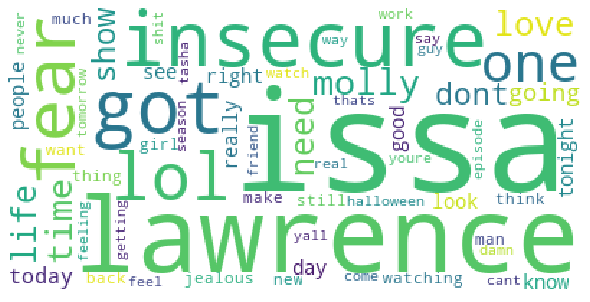

In [0]:
gen_cloud(train_df[train_df['emotion']=='fear']['cleanedText'])

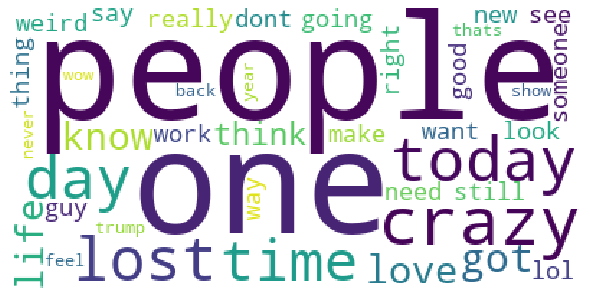

In [0]:
gen_cloud(train_df[train_df['emotion']=='surprise']['cleanedText'])

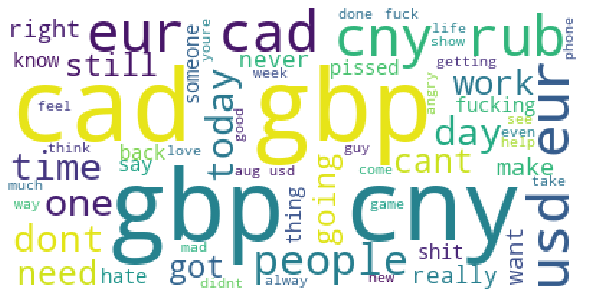

In [0]:
gen_cloud(train_df[train_df['emotion']=='anger']['cleanedText'])

After generating word cloud per emotion, we can see that:
- there are many words that are common/frequent across multiple emotions (e.g. "love", "life", "today")
- the top 20 words in the *all dataset* don't necessarily all belong to those in the 'joy' emotion, even if most tweets are categorized as 'joy'
- some interesting topics that stand out are: currency in *anger*, trump in *sadness/disgust*, and god/faith/religion in *joy, anticipation, trust.*

# Data Preprocessing

In [0]:
# cleaning data
import string
import re
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from collections import Counter 
!pip install emoji --upgrade
import emoji

def get_pos( word ):
    w_synsets = wordnet.synsets(word)

    pos_counts = Counter()
    pos_counts["n"] = len(  [ item for item in w_synsets if item.pos()=="n"]  )
    pos_counts["v"] = len(  [ item for item in w_synsets if item.pos()=="v"]  )
    pos_counts["a"] = len(  [ item for item in w_synsets if item.pos()=="a"]  )
    pos_counts["r"] = len(  [ item for item in w_synsets if item.pos()=="r"]  )
    
    most_common_pos_list = pos_counts.most_common(3)
    return most_common_pos_list[0][0] # first indexer for getting the top POS from list, second indexer for getting POS from tuple( POS: count )

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w, get_pos(w)) for w in w_tokenizer.tokenize(text)]

# lowercase
# all_df['cleanedText']=all_df['text'].str.lower()

# remove user mentions @
all_df['cleanedText'] = all_df['text'].apply(lambda x: re.sub("@[A-Za-z0-9]+","",x))

# convert emojis to words with emoji library
all_df['cleanedText'] = all_df['cleanedText'].apply(lambda x: emoji.demojize(x, delimiters=("", " ")))

# remove symbols
all_df['cleanedText']=all_df['cleanedText'].replace('[^a-zA-Z ]', '', regex=True)

# lemmatize
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer=WordNetLemmatizer()

all_df['cleanedText'] = all_df['cleanedText'].apply(lemmatize_text)
all_df['cleanedText'] = all_df['cleanedText'].apply(' '.join)

# remove 'lh'
all_df['cleanedText'] = all_df['cleanedText'].apply(lambda x: x.replace('lh',''))
all_df['cleanedText'] = all_df['cleanedText'].apply(lambda x: x.replace('LH',''))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 51kB 1.8MB/s 
  Created wheel for emoji: filename=emoji-0.5.4-cp36-none-any.whl size=42175 sha256=9309871a9170ddfdf95e8aa975d0256afdd3343823c846df594082aa1bc74404
  Stored in directory: /root/.cache/pip/wheels/2a/a9/0a/4f8e8cce8074232aba240caca3fade315bb49fac68808d1a9c
Successfully built emoji


In [0]:
all_df[::20]

,hashtags,tweet_id,text,identification,cleanedText
0,[Snapchat],0x376b20,"People who post ""add me on #Snapchat"" must be ...",train,People who post add me on Snapchat must be deh...
20,[ThankULord],0x2c49da,Giving thanks to my lord and savior for allowi...,train,Giving thanks to my lord and savior for allow ...
40,"[hangry, needfood]",0x2ac7bd,Hangry and ready to snap. #hangry <LH> #needfo...,train,Hangry and ready to snap hangry needfood neut...
60,[scared],0x2bf9ce,Saw the county's bitch today. Pulled up next t...,train,Saw the county bitch today Pulled up next to h...
80,[],0x37e94f,Happy Thanksgiving <LH> 🦃🦃,train,Happy Thanksgiving turkey turkey
...,...,...,...,...,...
1867440,[],0x238871,@FifiLarue2 I've called several times as well....,test,Ive call several time a well At least we can l...
1867460,[],0x1dd66f,@nytimes Well...isn’t that just a heartwarming...,train,Wellisnt that just a heartwarming story that e...
1867480,[Life],0x3810f1,71 The moments in your life are only once #Lif...,train,The moment in your life be only once Life ...
1867500,[],0x348b96,I've got Agust D stuck in my head. WHY CANT YO...,train,Ive get Agust D stick in my head WHY CANT YOU ...


In [0]:
# save to pkl
all_df.to_pickle("/content/drive/My Drive/Colab Notebooks/lab2/all_df_stopwords2lw_wordemojis_preservecaps.pkl") 

In [0]:
# split into train and test
test_df = all_df[all_df['identification']=='test']
train_df = all_df[all_df['identification']=='train']
train_df = pd.merge(train_df, emotion, on='tweet_id')

We do standard data cleaning methods. It's interesting to note that we do not remove stopwords and do not lowercase all words as these are actually important indicators of emotions. The classifiers I tried also all performed better when I kept stopwords and capitalization.

# Feature Creation

In [0]:
# Count Vectorizer

from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import TweetTokenizer

tknzr = TweetTokenizer(strip_handles=True)

count_vect = CountVectorizer(max_features=90000, tokenizer=tknzr.tokenize)

# fit
count_vect.fit(train_df['cleanedText'])

# transformed
transformed = count_vect.transform(train_df['cleanedText'])

In [0]:
# TF IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import TweetTokenizer

tknzr = TweetTokenizer(strip_handles=True)

vectorizer = TfidfVectorizer(max_features=200000, tokenizer=tknzr.tokenize)

# fit
vectorizer.fit(train_df['cleanedText'])

# transformed
tfidftransformed = vectorizer.transform(train_df['cleanedText'])

In [0]:
import pickle

#pickle.dump(vectorizer, open("/content/drive/My Drive/Colab Notebooks/lab2/all_df_stopwords2lw_wordemojis_preservecaps_vectorizer.pickle", "wb"))

# load fit vectorizer
vectorizer = pickle.load(open("/content/drive/My Drive/Colab Notebooks/lab2/all_df_stopwords2lw_wordemojis_tfidfvectorizer.pickle", 'rb'))
# transformed
#tfidftransformed = vectorizer.transform(train_df['cleanedText'])

In [7]:
tfidftransformed

<1455563x200000 sparse matrix of type '<class 'numpy.float64'>'
	with 17033972 stored elements in Compressed Sparse Row format>

# Model Explanation

**MODELS I ATTEMPTED**

The last 4 sections each outline the different methods I tried. I tried 4 models:

1. Naive Bayes
2. Logistic Regression
3. FastText
4. Keras Deep Neural Network

For each method, I split the train data into train and validation set, plotted confusion matrix, re-trained on all data then predicted and output the results for test set. Here are my takeaways:

**Naive Bayes**
*   Chosen because it performs well with text data and is fast
*   Features are BoW as Multinomial NB works best with word counts
*   Highest score: 0.43429

**Logistic Regression**
*   Chosen because it is also very fast! It only takes around ten minutes to train. It also has the ability to "transparently study the importance of individual features" [Source: https://web.stanford.edu/~jurafsky/slp3/5.pdf], which is important in text classification.
*   Features are TFIDF 
*   Highest score: 0.45500

**Fast Text Classifier**
*   Chosen because it is good at dealing with out of vocabulary and mispelled words (common with Tweets), and is the fastest (only takes around 5 min to train). It also handles class imbalance well. 
*   Features are TFIDF 
*   Highest score: 0.45709

**Keras Neural Network Clasifier**
*   Chosen because they are often accurate, robust, and powerful.
*   Features are TFIDF 
*   Highest score: 0.46089


**Other Takeaways**
- It is important to clean the data properly. We don't want to lose important information when cleaning. For example, stopwords and capitalized letters actually help identify some emotion.  We have to balance it with the sparsity of the data, though - we should remove all meaningless features.
- It is a challenge to deal with imbalanced classes as the model might tend to predict everything as the majority class and worsen recall. We should choose classifiers that can deal with imbalanced data well or perform other methods like upsampling or downsampling.
- It is challenging to figure out the right parameters for the neural network, setting the wrong number could change the score greatly. Appropriate cross fold validations measures should be applied.





# Naive Bayes

In [0]:
# validate: split into train and test

### Multinomial NB, using word frequency features
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(transformed, train_df['emotion'], test_size=0.2, random_state=10)

Accuracy Score: 0.5070608320480363
              precision    recall  f1-score   support

       anger       0.95      0.10      0.17      7894
anticipation       0.65      0.44      0.53     49809
     disgust       0.53      0.25      0.34     27838
        fear       0.89      0.18      0.30     12877
         joy       0.47      0.90      0.62    103260
     sadness       0.48      0.38      0.43     38693
    surprise       0.88      0.10      0.19      9754
       trust       0.66      0.16      0.26     40988

    accuracy                           0.51    291113
   macro avg       0.69      0.32      0.35    291113
weighted avg       0.58      0.51      0.46    291113



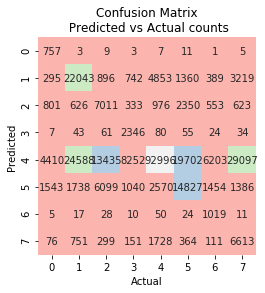

In [0]:
# model and print confusion matrix
mnmodel = MultinomialNB()
mnmodel.fit(X_train, y_train)
y_pred = mnmodel.predict(X_test)

mnconfusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(mnconfusion_matrix.T, 
               square  = True,
               annot = True,
               fmt = "d",
               cbar = False,
               cmap = "Pastel1")

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Confusion Matrix\n Predicted vs Actual counts")

print('Accuracy Score:', accuracy_score(y_test, y_pred))
print(classification_report(y_true=y_test, y_pred=y_pred))

In [0]:
# train all over again
X_train = transformed
y_train = train_df['emotion']
X_test = count_vect.transform(test_df['cleanedText'])

# fit model
mnmodel.fit(X_train, y_train)

# predict
mnresults = mnmodel.predict(X_test)

# output to csv
test_df['emotion'] = mnresults

output = test_df[['tweet_id', 'emotion']].copy()
output.to_csv("new attempt5.csv", index=False)
test_df


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,hashtags,tweet_id,text,identification,cleanedText,emotion
2,[bibleverse],0x28b412,"Confident of your obedience, I write to you, k...",test,Confident of your obedience I write to you kno...,anticipation
4,[],0x2de201,"""Trust is not the same as faith. A friend is s...",test,Trust be not the same a faith A friend be some...,anticipation
9,"[materialism, money, possessions]",0x218443,When do you have enough ? When are you satisfi...,test,When do you have enough When be you satisfy Is...,anticipation
30,"[GodsPlan, GodsWork]",0x2939d5,"God woke you up, now chase the day #GodsPlan #...",test,God wake you up now chase the day GodsPlan God...,anticipation
33,[],0x26289a,"In these tough times, who do YOU turn to as yo...",test,In these tough time who do YOU turn to a your ...,anticipation
...,...,...,...,...,...,...
1867525,[],0x2913b4,"""For this is the message that ye heard from th...",test,For this be the message that ye hear from the ...,anticipation
1867529,[],0x2a980e,"""There is a lad here, which hath five barley l...",test,There be a lad here which hath five barley loa...,anticipation
1867530,"[mixedfeeling, butimTHATperson]",0x316b80,When you buy the last 2 tickets remaining for ...,test,When you buy the last ticket remain for a show...,joy
1867531,[],0x29d0cb,I swear all this hard work gone pay off one da...,test,I swear all this hard work go pay off one days...,joy


# Logistic Regression

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[LibLinear]Accuracy Score: 0.4994830186216349
              precision    recall  f1-score   support

       anger       0.21      0.44      0.28      7946
anticipation       0.58      0.56      0.57     49984
     disgust       0.40      0.43      0.42     27669
        fear       0.33      0.51      0.40     12846
         joy       0.66      0.57      0.62    102943
     sadness       0.46      0.43      0.44     38745
    surprise       0.21      0.35      0.26      9816
       trust       0.46      0.40      0.43     41164

    accuracy                           0.50    291113
   macro avg       0.42      0.46      0.43    291113
weighted avg       0.53      0.50      0.51    291113



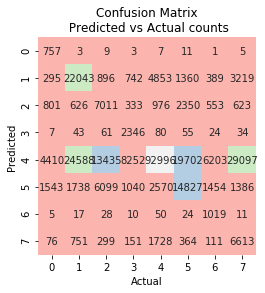

In [0]:
# validate: split into train and test
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(tfidftransformed, train_df['emotion'], test_size=0.2, random_state=42)

# model
lr = LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, max_iter=1000,
                   multi_class='warn', n_jobs=-1, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=2,
                   warm_start=False)

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# print confusion matrix

lrconfusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(mnconfusion_matrix.T, 
               square  = True,
               annot = True,
               fmt = "d",
               cbar = False,
               cmap = "Pastel1")

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Confusion Matrix\n Predicted vs Actual counts")

print('Accuracy Score:', accuracy_score(y_test, y_pred))
print(classification_report(y_true=y_test, y_pred=y_pred))

In [0]:
# train all over again on entire dataset

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, max_iter=1000,
                   multi_class='warn', n_jobs=-1, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=1,
                   warm_start=False)

X_train = tfidftransformed
y_train = train_df['emotion']
X_test = vectorizer.transform(test_df['cleanedText'])

# fit model
lr.fit(X_train, y_train)

# predict
lrresults = lr.predict(X_test)

# output to csv
test_df['emotion'] = lrresults

output = test_df[['tweet_id', 'emotion']].copy()
output.to_csv("newattempt6.csv", index=False)
test_df


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[LibLinear]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,hashtags,tweet_id,text,identification,cleanedText,emotion
2,[bibleverse],0x28b412,"Confident of your obedience, I write to you, k...",test,Confident of your obedience I write to you kno...,trust
4,[],0x2de201,"""Trust is not the same as faith. A friend is s...",test,Trust be not the same a faith A friend be some...,anticipation
9,"[materialism, money, possessions]",0x218443,When do you have enough ? When are you satisfi...,test,When do you have enough When be you satisfy Is...,anticipation
30,"[GodsPlan, GodsWork]",0x2939d5,"God woke you up, now chase the day #GodsPlan #...",test,God wake you up now chase the day GodsPlan God...,anticipation
33,[],0x26289a,"In these tough times, who do YOU turn to as yo...",test,In these tough time who do YOU turn to a your ...,trust
...,...,...,...,...,...,...
1867525,[],0x2913b4,"""For this is the message that ye heard from th...",test,For this be the message that ye hear from the ...,anticipation
1867529,[],0x2a980e,"""There is a lad here, which hath five barley l...",test,There be a lad here which hath five barley loa...,anticipation
1867530,"[mixedfeeling, butimTHATperson]",0x316b80,When you buy the last 2 tickets remaining for ...,test,When you buy the last ticket remain for a show...,sadness
1867531,[],0x29d0cb,I swear all this hard work gone pay off one da...,test,I swear all this hard work go pay off one days...,anger


# Fast Text

In [0]:
# install
!git clone https://github.com/facebookresearch/fastText.git
%cd fastText
!pip install .

Cloning into 'fastText'...
remote: Enumerating objects: 3531, done.
remote: Total 3531 (delta 0), reused 0 (delta 0), pack-reused 3531
Receiving objects: 100% (3531/3531), 8.02 MiB | 38.00 MiB/s, done.
Resolving deltas: 100% (2225/2225), done.
/content/fastText
Processing /content/fastText
  Created wheel for fasttext: filename=fasttext-0.9.1-cp36-cp36m-linux_x86_64.whl size=2824964 sha256=2dbe652e4cfd5e2f3c6587ebcac1e8a7018118d156cf460b206793ae79485890
  Stored in directory: /tmp/pip-ephem-wheel-cache-d6hhn5o2/wheels/a1/9f/52/696ce6c5c46325e840c76614ee5051458c0df10306987e7443
Successfully built fasttext


In [0]:
train_df['FTemotion'] = train_df['emotion'].apply(lambda x: "__label__" + x)

In [0]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(train_df, test_size=0.2)

ft_train = pd.DataFrame()
ft_train['text'] = train['FTemotion'] + ' ' + train['cleanedText']
ft_train.to_csv(r'/content/drive/My Drive/Colab Notebooks/lab2/ft_train.txt', index=False, header=False)

ft_test = pd.DataFrame()
ft_test['text'] = test['FTemotion'] + ' ' + test['cleanedText']
ft_test.to_csv(r'/content/drive/My Drive/Colab Notebooks/lab2/ft_test.txt', index=False, header=False)

In [0]:
import fasttext

# train model
ft_model = fasttext.train_supervised(input="/content/drive/My Drive/Colab Notebooks/lab2/ft_train.txt", autotuneValidationFile="/content/drive/My Drive/Colab Notebooks/lab2/ft_test.txt", autotuneDuration=600)
#ft_model = fasttext.train_supervised(input= "/content/drive/My Drive/Colab Notebooks/lab2/ft_train.txt")


In [0]:
ft_model.save_model("ft_model.bin")

In [0]:
# print model parameters
print("LR:", ft_model.lr)
print("Dim:",ft_model.dim)
print("WS:",ft_model.ws)
print("Epoch:",ft_model.epoch)
print("minCount:",ft_model.minCount)
print("minCountLabel:",ft_model.minCountLabel)
print("minn:",ft_model.minn)
print("maxn:",ft_model.maxn)
print("neg:",ft_model.neg)
print("wordNgrams:",ft_model.wordNgrams)
print("loss:",ft_model.loss)
print("bucket:",ft_model.bucket)
print("thread:",ft_model.thread)
print("lrUpdateRate:",ft_model.lrUpdateRate)
print("t:",ft_model.t)
print("label:",ft_model.label)
print("verbose:",ft_model.verbose)
print("pretrainedVectors:",ft_model.pretrainedVectors)

LR: 0.1
Dim: 300
WS: 5
Epoch: 5
minCount: 1
minCountLabel: 0
minn: 0
maxn: 0
neg: 5
wordNgrams: 1
loss: loss_name.softmax
bucket: 0
thread: 3
lrUpdateRate: 100
t: 0.0001
label: __label__
verbose: 2
pretrainedVectors: /content/drive/My Drive/Colab Notebooks/lab2/crawl-300d-2M.vec


In [0]:
# get accuracy score
ft_model.test("/content/drive/My Drive/Colab Notebooks/lab2/ft_test.txt")

(291113, 0.5367949902615136, 0.5367949902615136)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


              precision    recall  f1-score   support

       anger       0.53      0.23      0.32      7984
anticipation       0.59      0.54      0.56     49536
     disgust       0.45      0.39      0.41     27786
        fear       0.61      0.37      0.46     12808
         joy       0.56      0.77      0.65    103419
     sadness       0.46      0.46      0.46     38571
    surprise       0.53      0.19      0.28      9757
       trust       0.52      0.30      0.38     41252

    accuracy                           0.54    291113
   macro avg       0.53      0.41      0.44    291113
weighted avg       0.53      0.54      0.52    291113



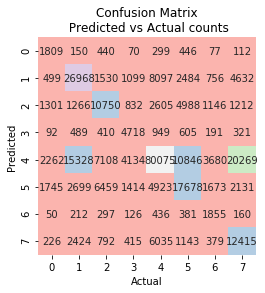

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

test['ftemotion'] = test['cleanedText'].apply(lambda x: str(ft_model.predict(x)[0]).replace('(\'__label__','').replace('\',)',''))
# print confusion matrix
ftconfusion_matrix = confusion_matrix(test['emotion'], test['ftemotion'])
sns.heatmap(ftconfusion_matrix.T, 
               square  = True,
               annot = True,
               fmt = "d",
               cbar = False,
               cmap = "Pastel1")

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Confusion Matrix\n Predicted vs Actual counts")

print(classification_report(y_true=test['emotion'], y_pred=test['ftemotion']))

In [0]:
# retrain on all data

ft_prep = pd.DataFrame()
ft_prep['text'] = train_df['FTemotion'] + ' ' + train_df['cleanedText']
ft_prep.to_csv(r'/content/drive/My Drive/Colab Notebooks/lab2/ft_prep.txt', index=False, header=False)

ft_model = fasttext.train_supervised(input="/content/drive/My Drive/Colab Notebooks/lab2/ft_prep.txt")
# ft_model = fasttext.train_supervised(input= "/content/drive/My Drive/Colab Notebooks/lab2/ft_prep.txt", dim= 300, pretrainedVectors="/content/drive/My Drive/Colab Notebooks/lab2/wiki-news-300d-1M-subword.vec")

In [0]:
# predict on test data
test_df['ftemotion'] = test_df['cleanedText'].apply(lambda x: str(ft_model.predict(x)[0]).replace('(\'__label__','').replace('\',)',''))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
# output to csv
output = test_df[['tweet_id', 'ftemotion']].copy()
output.to_csv("newattempt8.csv", index=False)
test_df[::10]

,hashtags,tweet_id,text,identification,cleanedText,ftemotion
2,[bibleverse],0x28b412,"Confident of your obedience, I write to you, k...",test,Confident of your obedience I write to you kno...,trust
57,[],0x25dcd8,Nothing like the delicious taste of coffee and...,test,Nothing like the delicious taste of coffee and...,joy
140,[],0x245e5b,@realDonaldTrump It's been on the news all day...,test,Its be on the news all day Ur just fishing pra...,joy
190,[PuertoRico],0x1f0f0d,@realDonaldTrump Other places have been hit by...,test,Other place have be hit by a Cat hurricane Its...,joy
220,"[GCCC, SCMP, yyc, certification, communications]",0x3186fc,"Well, I did it. I registered to write the @IAB...",test,Well I do it I register to write the GCCC SCMP...,anticipation
...,...,...,...,...,...,...
1867374,[],0x382ea8,@MensHealthUK unnecessary ridiculous step... m...,test,unnecessary ridiculous step mean only to get f...,disgust
1867425,[],0x1f3864,Would quite happily drive Woolshite to any foo...,test,Would quite happily drive Woolshite to any foo...,sadness
1867454,[dontcare],0x365115,3rd week of school and I already got yelled at...,test,rd week of school and I already get yell at sm...,disgust
1867506,[],0x22a4b8,@JasamNation @ImmaDoMe_mmk @slantz88 @GeneralH...,test,mmk Dont matter anyway the whole Jasam history...,anticipation


# Neural Network

In [8]:
import keras
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

X_train = tfidftransformed
y_train = train_df['emotion']
X_test = vectorizer.transform(test_df['cleanedText'])

## check dimensions
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)

X_train.shape:  (1455563, 200000)
y_train.shape:  (1455563,)
X_test.shape:  (411972, 200000)


In [9]:
## deal with label (string -> one-hot)

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(y_train)
print('check label: ', label_encoder.classes_)
print('\n## Before convert')
print('y_train[0:8]:\n', y_train[0:8])
print('\ny_train.shape: ', y_train.shape)
# print('y_test.shape: ', y_test.shape)

def label_encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)

y_train = label_encode(label_encoder, y_train)
# y_test = label_encode(label_encoder, y_test)

# print('\n\n## After convert')
# print('y_train[0:8]:\n', y_train[0:8])
# print('\ny_train.shape: ', y_train.shape)
# print('y_test.shape: ', y_test.shape)

check label:  ['anger' 'anticipation' 'disgust' 'fear' 'joy' 'sadness' 'surprise'
 'trust']

## Before convert
y_train[0:8]:
 0    anticipation
1         sadness
2            fear
3             joy
4    anticipation
5             joy
6         sadness
7    anticipation
Name: emotion, dtype: object

y_train.shape:  (1455563,)


In [10]:
# Build model
# I/O check
input_shape = X_train.shape[1]
print('input_shape: ', input_shape)

output_shape = len(label_encoder.classes_)
print('output_shape: ', output_shape)

input_shape:  200000
output_shape:  8


In [11]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import ReLU, Softmax

# input layer
model_input = Input(shape=(input_shape, ))  
X = model_input

# 1st hidden layer
X_W1 = Dense(units=64)(X)  
H1 = ReLU()(X_W1)

# 2nd hidden layer
H1_W2 = Dense(units=64)(H1)  
H2 = ReLU()(H1_W2)

# output layer
H2_W3 = Dense(units=output_shape)(H2)  
H3 = Softmax()(H2_W3)

model_output = H3

# create model
model = Model(inputs=[model_input], outputs=[model_output])

# loss function & optimizer
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# show model construction
model.summary()






Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                12800064  
_________________________________________________________________
re_lu_1 (ReLU)               (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
re_lu_2 (ReLU)               (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 520       
_________________________________________________________________
softmax_1 (Softmax)          (None, 8)                

In [13]:
from keras.callbacks import CSVLogger

csv_logger = CSVLogger('training_log.csv')

# training setting

# sadly, since this is one of the last things I tried I only had time to train 1 epoch :(
epochs = 1
batch_size = 32

# training!
history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    callbacks=[csv_logger])
print('training finish')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/1





1455563/1455563 [==============================] - 1295s 890us/step - loss: 1.2760 - acc: 0.5380
training finish


In [14]:
# predict and output to csv
pred_result = model.predict(X_test, batch_size=128)
pred_result = label_decode(label_encoder, pred_result)
test_df['emotion']=pred_result
output = test_df[['tweet_id', 'emotion']].copy()
output.to_csv("newattempt12.csv", index=False)
test_df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,hashtags,tweet_id,text,identification,cleanedText,emotion
2,[bibleverse],0x28b412,"Confident of your obedience, I write to you, k...",test,Confident of your obedience I write to you kno...,anticipation
4,[],0x2de201,"""Trust is not the same as faith. A friend is s...",test,Trust be not the same a faith A friend be some...,anticipation
9,"[materialism, money, possessions]",0x218443,When do you have enough ? When are you satisfi...,test,When do you have enough When be you satisfy Is...,anticipation
30,"[GodsPlan, GodsWork]",0x2939d5,"God woke you up, now chase the day #GodsPlan #...",test,God wake you up now chase the day GodsPlan God...,anticipation
33,[],0x26289a,"In these tough times, who do YOU turn to as yo...",test,In these tough time who do YOU turn to a your ...,trust
...,...,...,...,...,...,...
1867525,[],0x2913b4,"""For this is the message that ye heard from th...",test,For this be the message that ye hear from the ...,anticipation
1867529,[],0x2a980e,"""There is a lad here, which hath five barley l...",test,There be a lad here which hath five barley loa...,anticipation
1867530,"[mixedfeeling, butimTHATperson]",0x316b80,When you buy the last 2 tickets remaining for ...,test,When you buy the last ticket remain for a show...,sadness
1867531,[],0x29d0cb,I swear all this hard work gone pay off one da...,test,I swear all this hard work go pay off one days...,joy
